In [206]:
import requests
import re

In [209]:
# get the full text of Carnegie Mellon Pronouncing Dictionary

url = "http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b"
f = requests.get(url)
d = f.text

# get rid of introduction
d = d.split("\n")[56:]

In [210]:
# create a dict with words as keys and pronunciations (as lists of phoneme strings) as values

pron_dict = {}

for entry in d:
    e = re.split(" +", entry)
    word = e[0]
    phonemes = [x[:2] for x in e[1:]] # x[:2] and not x in order to snip off Arpabet stress numbers (e.g. "AE1")
    pron_dict[word] = phonemes
    
def are_homophones(a, b):
    # a function to help us recognize homophones (e.g. RODE and ROAD), which might be useful later
    return pron_dict[a] == pron_dict[b]

In [211]:
# create a new version of pron_dict where the phoneme lists making up the values are sorted.
# this means that keys which are phonoanagrams of each other (e.g. DESK, DECKS) will have the same values.

pron_dict_sorted = {}

for word in pron_dict:
    pron_dict_sorted[word] = sorted(pron_dict[word])

In [212]:
# finally, create a dict with the sorted phoneme lists (converted to strings) as keys,
# and lists of words that have those phoneme sets as values.

phoneme_keys = {}

for word in pron_dict_sorted:
    pron = " ".join(pron_dict_sorted[word])
    if pron not in phoneme_keys:
        phoneme_keys[pron] = []
    phoneme_keys[pron].append(word)

In [213]:
def find_phonoanagrams(raw_word):
    """ Inputs any word in the CMU dict and returns its phonoanagrams. """
    word = raw_word.upper()
    
    try:
        phonemes_sorted = pron_dict_sorted[word]
    except KeyError:
        print("Unfortunately,", raw_word, "is not an entry in CMUDict.")
        return None
    
    phonemes_sorted = " ".join(phonemes_sorted)
    phonoanagrams = phoneme_keys[phonemes_sorted]
    results = [x for x in phonoanagrams if not are_homophones(word, x)]
    
    return results

def print_phonoanagrams(raw_word):
    results = find_phonoanagrams(raw_word)
    
    word = raw_word.upper()
    phonemes_sorted = pron_dict_sorted[word]
    phonemes_sorted = " ".join(phonemes_sorted)
    
    print("Sorted phonemes for", word, ":", phonemes_sorted)
    
    n = len(results)
    if n == 0:
        print("Found zero phonoanagrams.")
    else:
        if n == 1:
            print("Found one phonoanagram:")
        else:
            print("Found", n, "phonoanagrams:")
        for wd in results:
            print(wd)
    
    return None

In [239]:
# type the word in here for which you want to find phonoanagrams:

print_phonoanagrams('solar')

Sorted phonemes for SOLAR : ER L OW S
Found one phonoanagram:
SLOWER


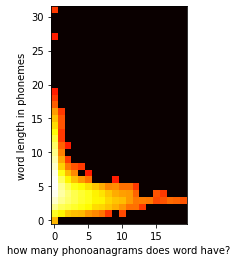

In [218]:
# to plot out word counts for every "word length in phonemes" x "phonoanagram count per word" combination:

import numpy as np
import matplotlib.pyplot as plt

# create 2-D array, mapping word length (in phonemes) vs. count of phonoanagrams yielded by word.

lengths = [len(x) for x in pron_dict.values()]
ph_counts = [len(find_phonoanagrams(x)) for x in pron_dict.keys()]

x = np.full((32, 20), 0.001, dtype=float)

for i in range(len(lengths)):
    row = lengths[i] - 1
    col = ph_counts[i]
    x[row][col] += 1
    
x = np.log(x) # optional: taking the log of the word counts will make the results more visible qualitatively

# create plot

fig, ax = plt.subplots()
ax.set_xlabel('how many phonoanagrams does word have?')
ax.set_ylabel('word length in phonemes')

plt.imshow(x, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()